In [38]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.model_selection import train_test_split, cross_val_score
from nltk.corpus import stopwords
import tensorflow as tf

In [39]:
EMBEDDING_FILE='glove.6B.50d.txt'
TEST_DATA_FILE='test.csv'
TRAIN_DATA_FILE=pd.read_csv("train.csv")

In [40]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

list_sentences_train = train["posts"]
list_classes = ["is_S"]
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_test = test["posts"]

In [42]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [43]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [44]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/Users/nalisha/opt/anaconda3/envs/hello/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [45]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [46]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])

In [47]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Epoch 1/2
220/220 [==============================] - 19s 86ms/step - loss: 0.6838 - precision_2: 0.5452 - val_loss: 0.6619 - val_precision_2: 0.6532
Epoch 2/2
220/220 [==============================] - 19s 85ms/step - loss: 0.6352 - precision_2: 0.6341 - val_loss: 0.6346 - val_precision_2: 0.6630


In [48]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Epoch 1/2
220/220 [==============================] - 19s 87ms/step - loss: 0.6772 - accuracy: 0.5734 - val_loss: 0.6571 - val_accuracy: 0.6069
Epoch 2/2
220/220 [==============================] - 19s 86ms/step - loss: 0.6261 - accuracy: 0.6486 - val_loss: 0.6307 - val_accuracy: 0.6287


In [50]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [51]:
batch_size = 32
epochs = 2

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)

Epoch 1/2

 ROC-AUC - epoch: 1 - score: 0.787530 

232/232 - 20s - loss: 0.5693 - accuracy: 0.7039 - val_loss: 0.5515 - val_accuracy: 0.7084
Epoch 2/2

 ROC-AUC - epoch: 2 - score: 0.785793 

232/232 - 19s - loss: 0.4949 - accuracy: 0.7642 - val_loss: 0.5614 - val_accuracy: 0.7187


In [52]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [53]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

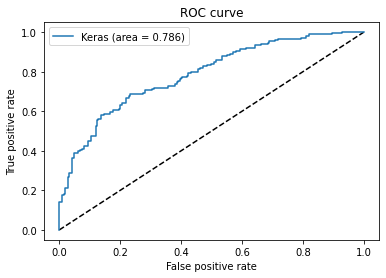

In [54]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()